In [85]:
import matplotlib.pyplot as plt
import paraview.simple as pvs
import pandas as pd
import math
from pathlib import Path


# Biocellion Output Plotting
This notebook defines functions to read and plot the biocellion output data for the Biocellion ABM models by the CMMC that can be found in github.com/TheCMMC. For more information on the CMMC, visit www.thecmmc.org.  

To use these plotting functions the biocellion output summary should be in one directory with the following naming pattern:
`output_parameter{par_id}_trial{trial}.txt`

If the scripts and instructions in https://github.com/TheCMMC/biocellion-tools have been used to create the output, this notebook should be able to run with the resulting data.

## User settings

In [3]:
# Set this data folder to the place where you cloned the repository https://github.com/TheCMMC/biocellion-data
DATA_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-data")
MODEL_OUTPUT_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output")
FIG_FOLDER = Path("./figures")

## Plotting functions

In [4]:
ABM_ONLY_FOLDER = DATA_FOLDER / "PLOSone_ABM-only-microcarrier"
ABM_CFD_FOLDER = DATA_FOLDER / "PLOSone_ABM-CFD-microcarrier"

In [148]:
def read_summary_file(par_id, trial, data_folder):
    filename = data_folder / f"output_parameter{par_id}_trial{trial}.txt"
    live, attached, dead, removed = ([],[],[],[])

    with open(filename, 'r' ) as f :
        for line in f:
            if 'Live Cells' in line :
              live.append( int( line.strip().split(':')[-1] ) )
            if 'Live Attached Cells' in line :
              attached.append( int( line.strip().split(':')[-1] ) )
            elif 'Death Cells' in line:
              dead.append( int( line.strip().split(':')[-1] ))
            elif 'Removed Cells' in line :
              removed.append( int( line.strip().split(':')[-1] ))
    
    # if the lengths of these list are different print error
    assert len(live)==len(attached)==len(dead)==len(removed), "Cell count lists are of different lenghts"

    return pd.DataFrame({"live":live, "attached":attached, "dead":dead, "removed":removed})

def load_parameter_set(par_id, data_folder, trials=range(1,11), as_dict=False):
    par_set = []
    for trial in trials:
        trial_data = read_summary_file(par_id, trial, data_folder)
        par_set.append(trial_data)
    if as_dict:
        par_set=dict(zip(trials,par_set))
    return par_set

def compute_statistics(par_set):
    par_set = pd.concat(par_set)
    grouped_par_set = par_set.groupby(par_set.index)
    means = grouped_par_set.mean()
    stds = grouped_par_set.std()
    stds = grouped_par_set.std()
    return means, stds

def plot_trials(par_id, data_folder, trials=range(1,11), states=["live", "attached", "dead", "removed"]):
    par_set = load_parameter_set(par_id, data_folder, trials=trials, as_dict=True)
    fig, ax = plt.subplots()
    for trial in trials:
        par_set[trial].plot(ax=ax, alpha=.5)
        ax.set_prop_cycle(None)

def plot_stats(par_id, data_folder, states=["live", "attached", "dead", "removed"], ax=None):
    if ax==None:
        fig, ax = plt.subplots()
    par_set = load_parameter_set(par_id, data_folder)
    means, stds = compute_statistics(par_set)
    under_line     = (means-stds)
    over_line      = (means+stds)
    ax.plot(means, label=means.columns)
    for state in states:
        ax.fill_between(stds.index, under_line[state], over_line[state], alpha=.3)
    ax.title.set_text(f"Statistics of parameter set {par_id}" )
    ax.legend(loc='upper left')
        
def plot_compare_rpms(par_ids, data_folder, states=["live", "attached", "dead", "removed"]):
    prows = math.ceil(len(par_ids)/2)
    fig, axs = plt.subplots(prows, 2, figsize=(20, 5*prows))
    axs=axs.flatten()
    for i, par_id in enumerate(par_ids): 
        plot_stats(par_id, data_folder, ax=axs[i])
    plt.savefig(FIG_FOLDER / f"compare_rpms_parid_{par_ids[0]}-{par_ids[-1]}.png")


<AxesSubplot:>

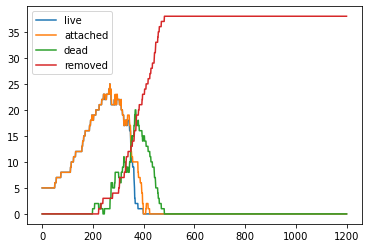

In [130]:
cell_counts = read_summary_file(17, 8, ABM_CFD_FOLDER)
cell_counts.plot()

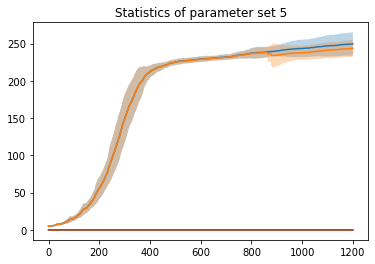

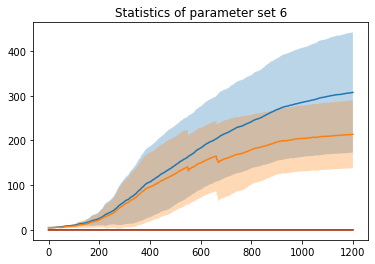

In [131]:
for i in range(5,7):
#     plot_trials(i, ABM_CFD_FOLDER)
    plot_stats(i, ABM_CFD_FOLDER)
    

# plot_multi_summary(range(5,32), range(1,11), ABM_CFD_FOLDER)

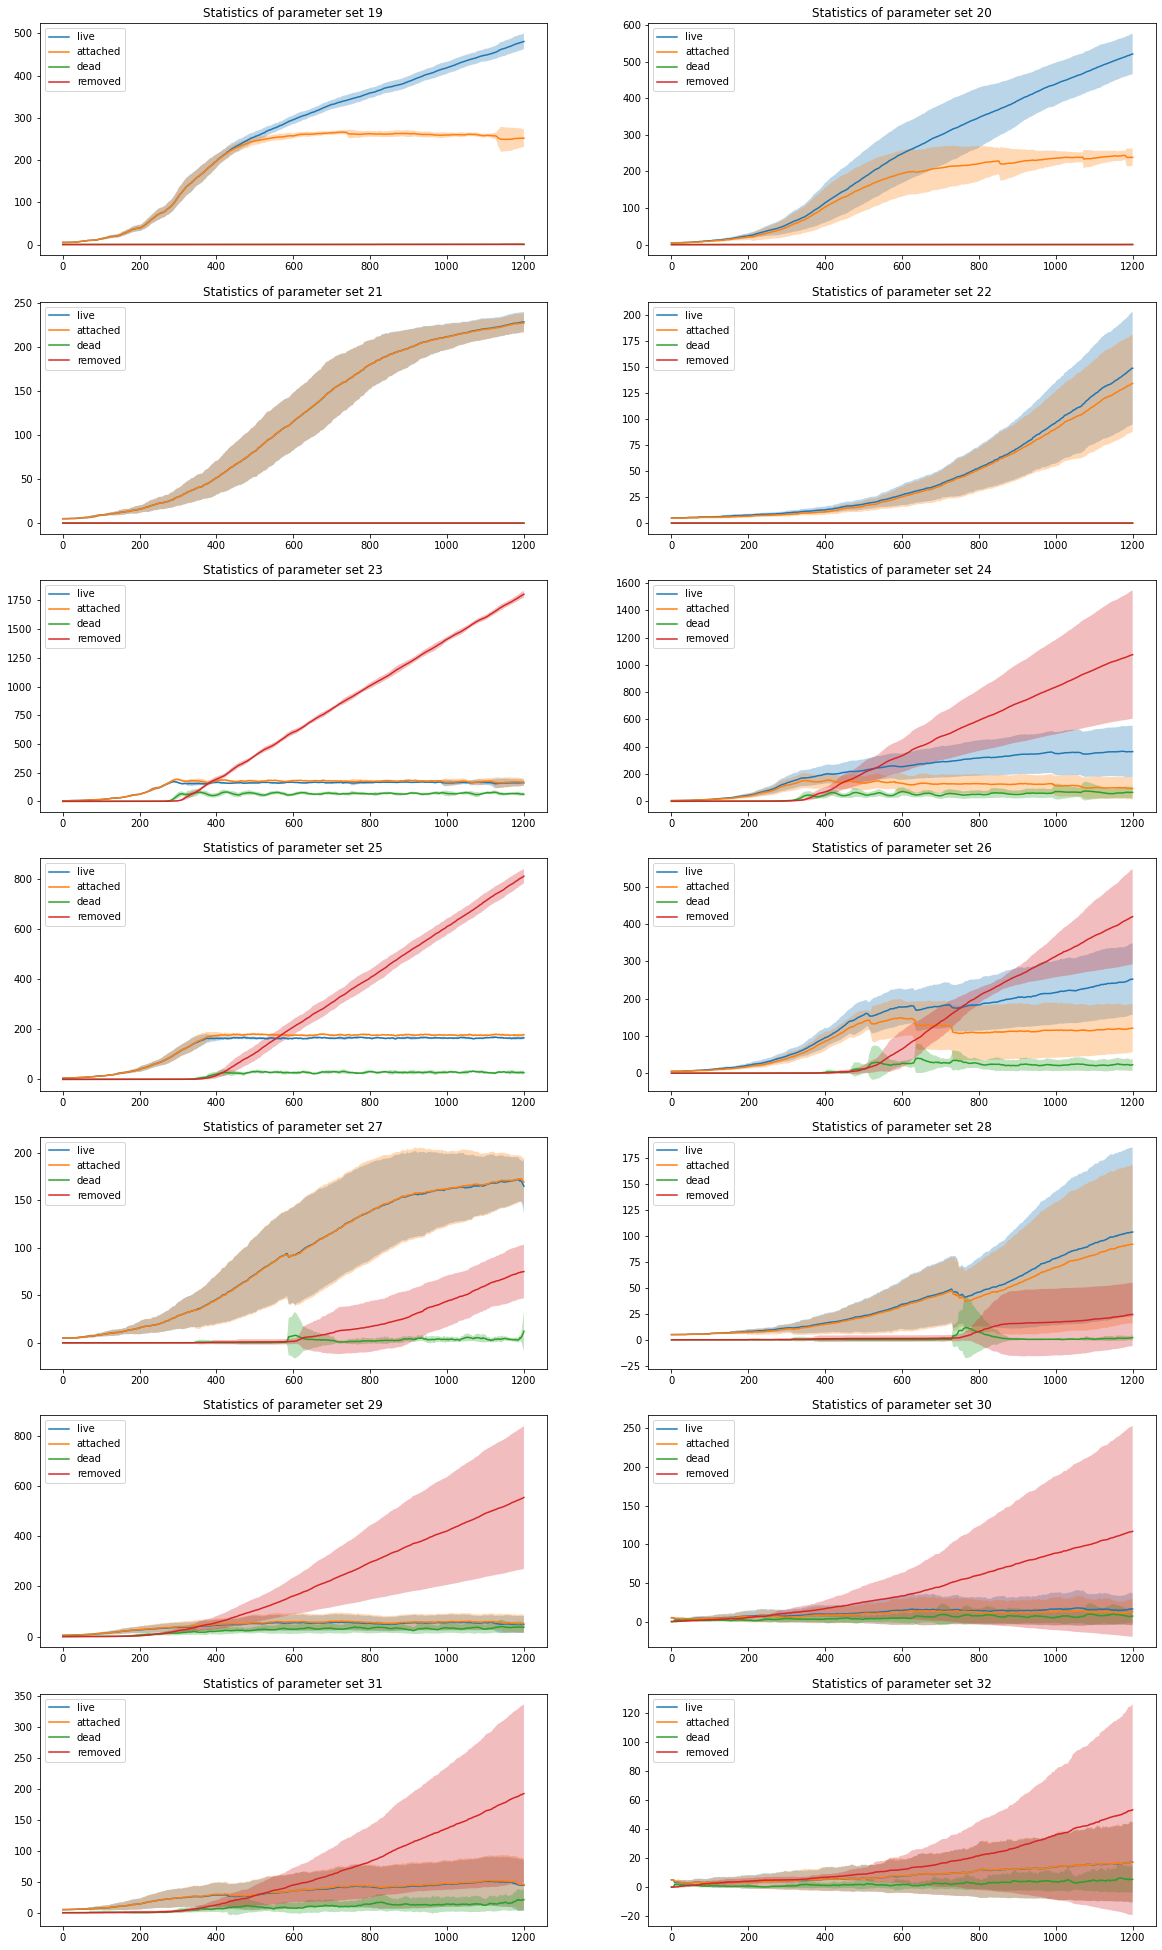

In [151]:
plot_compare_rpms(range(19,33), ABM_CFD_FOLDER)

In [ ]:
from paraview import servermanager as sm
from paraview.vtk.numpy_interface import dataset_adapter as dsa

def read_pvtp_files(pvtp_folder, stop, start=0, interval=1):
    pvs._DisableFirstRenderCameraReset()
    for step in range(start, stop, interval):
        file_name = pvtp_folder / f'agent_{str(step).zfill(5)}.pvtp'
        print(file_name)
        reader = pvs.XMLPartitionedPolydataReader(FileName = str(file_name))
        vtk_data = sm.Fetch(reader)
        help(reader)
#         print(vtk_data.GetPointData())
        
        object_data = dsa.WrapDataObject(vtk_data)
        data = object_data.GetPointData()
#         print(step, data.GetName(1) , data.GetArray(1))
        pvs.Delete(reader)
    return 
        
def plot_single_cells(par_id, trial, model_folder):
    pvtp_folder = model_folder / f"output_parameter{par_id}_trial{trial}"
#     print(pvtp_folder)
    read_pvtp_files(pvtp_folder, 30000, 20000, 2000)
    return

In [351]:
plot_single_cells(5, 2, MODEL_OUTPUT_FOLDER)

/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers/output/output_parameter5_trial2/agent_20000.pvtp
Help on XMLPartitionedPolydataReader in module paraview.servermanager object:

class XMLPartitionedPolydataReader(SourceProxy)
 |  XMLPartitionedPolydataReader(**args)
 |  
 |  The
 |  XML Partitioned Polydata reader reads the partitioned VTK
 |  polydata file format. It reads the partitioned format's
 |  summary file and then the associated VTK XML polydata
 |  files. The expected file extension is .pvtp. This reader
 |  also supports file series.
 |  
 |  Method resolution order:
 |      XMLPartitionedPolydataReader
 |      SourceProxy
 |      Proxy
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Initialize = aInitialize(self, connection=None, update=True)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  CellArrayStatus
 |      This proper

In [156]:
from paraview import servermanager as sm
from paraview.vtk.numpy_interface import dataset_adapter as dsa

...

vtk_data = sm.Fetch(pv_object)
vtk_data = dsa.WrapDataObject(vtk_data)
data = vtk_data.PointData[0]

NameError: name 'file' is not defined